<a href="https://colab.research.google.com/github/Patrick5455/Zimnat-Insurance-Challenge/blob/master/modelling_notebook_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Utilities

In [2]:
!pip install catboost
!pip install lightgbm
! pip install scikit-multilearn
!pip install community
!pip install networkx

     |████████████████████████████████| 66.1MB 57kB/s 
     |████████████████████████████████| 92kB 2.4MB/s 


In [3]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import date,  datetime
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Preprocessing & Data preparation


In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

#### MOdel Estimators

In [5]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
import catboost as cat
import lightgbm as light
from catboost import CatBoostClassifier, Pool
from sklearn.multiclass import OneVsRestClassifier

from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset

from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD

##### Model Improvement

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifierCV
from catboost import Pool, cv, MetricVisualizer

##### Model Estimators

In [7]:
from sklearn.metrics import log_loss

### import datasets

local path

In [8]:
# test_path = '../datasets/Test.csv'
# train_path = '../datasets/Train.csv'
# sample_submission_path = '../datasets/SampleSubmission.csv'

colab

mount drive

In [9]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AH9AYT2B-unS7B8OhUN3Fbw_eP33rJVK47HE87Egqw4XK9gOCfLSYI
Mounted at /content/drive


dfine data path from google drive

In [10]:
test_path = '/content/drive/My Drive/Zindi-Competionts/zimnat_Challenge_predicting_insurance_purchase/datasets/Test.csv'
train_path = '/content/drive/My Drive/Zindi-Competionts/zimnat_Challenge_predicting_insurance_purchase/datasets/Train.csv'
sample_submission_path = '/content/drive/My Drive/Zindi-Competionts/zimnat_Challenge_predicting_insurance_purchase/datasets/SampleSubmission.csv'

> define utitlity functions

load data

In [11]:
def load_data(path=""):
    data = pd.read_csv(path)
    return data

move columns

In [12]:
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()    
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1] 
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

transform dates

In [13]:
def transform_dates(df, col_name='', calc_age=False, 
                    birth_year_col_name = '', drop_date=True):
    df[col_name] = pd.to_datetime(df[col_name])
    #fill empty date columns
    if df[col_name].isna().any() == True:
        fill_date = df[col_name].mode()[0]
        df[col_name] =  df[col_name].fillna(fill_date)
    
    #create new datelike features
    todays_date = date.today()
    todays_date = pd.to_datetime(todays_date)
    
    df['duration_till_date'] = (todays_date - df[col_name]).astype('str').apply(lambda x: x.split(' d'
                                                                             )[0].strip()).astype('int64')
    
    df['year'] = df[col_name].apply(lambda x: x.year)
    df['month'] = df[col_name].apply(lambda x: x.year)
    df['week_of_year'] = df[col_name].apply(lambda x: x.weekofyear)
    df['day_of_week'] = df[col_name].apply(lambda x: x.dayofweek)
    
    if calc_age:
        
        df['age'] = df['year'] - df[birth_year_col_name]
        
    
    if drop_date:
        df.drop(columns=[col_name], inplace=True)
        
    
    return df

In [14]:
def val_counts(df, columns=[]):
    for col in columns:
        print("**"*8)
        print(col)
        print("**"*8) 
        print(df[col].value_counts()) 

##### encode categorical variables

In [15]:
def encode_cat(df:pd.DataFrame, cols_to_drop:list=[]) -> pd.DataFrame:
  if len(cols_to_drop) > 0:
    df = df.drop(cols_to_drop, axis=1)
  obj_columns = df.select_dtypes(include='object').columns
  for col in obj_columns:
    if len(df[col].value_counts()) == 2:
     df = pd.get_dummies(data=df, columns=[col], drop_first=True)
    else:
      df = pd.get_dummies(data=df, columns=[col])
  return df

##### binarize multi-labels

In [16]:
def binarize_labels(df:pd.DataFrame, prod_start_index=13, non_prod_start_index=12) -> pd.DataFrame:
  product_ids = df.columns.to_list()[prod_start_index:]
  non_product_cols = df.iloc[:, :non_prod_start_index].columns.tolist()
  df = df.melt(id_vars = non_product_cols, value_vars = product_ids, var_name='product_ids', value_name='labels')

  return df

#### create submission columns

In [17]:
def concat_prod_code(df) -> pd.DataFrame:
  df.sort_values(by=['ID','product_ids' ], inplace=True)
  df['ID X PCODE'] = df.ID+' X '+df.product_ids
  df = movecol(df, cols_to_move=['ID X PCODE'], ref_col='ID')

  return df

#### label a product in relation to percentile

- 10% very poor

- 25% poor

- 50% average

- 75% good

- 100% excellent

In [18]:
def rank_product_purhcase(df, penalize=False) -> pd.DataFrame:

  new_df = df.copy()

  # groupby product ids and labels
  class_counts_per_products = pd.DataFrame(new_df.groupby(['product_ids', 'labels'])['labels'].count()
            ).rename(columns={'labels':'vals'})
    
  # pivot frame
  class_counts_per_products = class_counts_per_products.reset_index().pivot(
    index='product_ids', columns='labels')
  
  # get main column of multindexed frame
  class_counts_per_products = class_counts_per_products['vals']

  # rename columns
  class_counts_per_products = class_counts_per_products.reset_index().rename(columns={0:'no_purchase', 1:'purchase'})

  #sort vlaues by purchases
  class_counts_per_products.sort_values(by='purchase', ascending=False, inplace=True)

  #define patronage label
  patronage_label = pd.DataFrame(class_counts_per_products.purchase.describe(percentiles=[
    .1,.25, .50, .75, 1])[['10%','25%','50%', '75%', '100%']]).reset_index().rename(columns={
    'index':'patronage', 'purchase':'value'})

  # rename index of paronage label
  patronage_label.rename(index={0:'very_poor', 1:'poor', 2:'avg', 3:'good', 4:'excellent'}, inplace=True)
  patronage_label.value = patronage_label.value.astype('int64') 

  # apply labels to class_counts_per_products
  pat_dic = patronage_label.value.to_dict()

  labels = []
  for i in class_counts_per_products.purchase:
      if i in range(0, pat_dic['very_poor']+1):
          labels.append('very_poor')
      elif i in range(pat_dic['very_poor']+1, pat_dic['poor']+1):
          labels.append('poor')
      elif i in range(pat_dic['poor']+1, pat_dic['avg']+1):
          labels.append('avg')
      elif i in range(pat_dic['avg']+1, pat_dic['good']+1):
          labels.append('good')
      elif i in range(pat_dic['good']+1, pat_dic['excellent']+1):
          labels.append('excellent')

  class_counts_per_products['ranks'] = labels

  rank_dic = dict(zip(class_counts_per_products.product_ids.to_list(), class_counts_per_products.ranks.to_list())) 

  #apply ranking to main data

  df_ranks =[]
  for i in df.product_ids:
      for k,v in rank_dic.items():
          if i.strip() == k.strip():
              df_ranks.append(v)

  df['product_ranks'] = df_ranks

  #convert ranks to ordinal values
  df.product_ranks = df.product_ranks.map({'excellent':5, 'good':4, 'avg':3,
                            'poor':2, 'very_poor':1})
  



  # deduct rank score from user who answer no i.e o to that product's purchase
  if penalize:
    df_zeroes_index = df.query('labels == 0').index
    
    df_zero_score = [0]*len(df_zeroes_index)

    df.loc[df_zeroes_index, 'product_ranks']  = df_zero_score
    

  return df





load data

In [19]:
test_set = load_data(test_path)
train_set = load_data(train_path)
sample_submission = load_data(sample_submission_path)

In [20]:
train_set

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,1/8/2019,M,M,1990,1X1H,BP09,56SI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,1/8/2019,M,M,1990,748L,NO3L,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29127,8SBA93U,1/9/2019,F,M,1974,748L,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
29128,Y73ETTO,1/11/2018,M,M,1987,XX25,Q6J6,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
29129,MVXG2LC,1/2/2019,M,M,1985,BOAS,6PE7,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
29130,BUQ8DQN,1/7/2019,M,M,1989,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [21]:
# train_set.occupation_code.nunique()

In [22]:
test_set

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,F86J5PC,1/12/2018,M,M,1984,94KC,DZRV,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H6141K3,1/10/2019,M,M,1996,1X1H,J9SY,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,RBAYUXZ,1/1/2020,F,W,1968,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,KCBILBQ,1/2/2019,M,M,1989,94KC,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LSEC1ZJ,1/2/2020,F,M,1982,UAOD,0KID,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0GMU5UH,1/4/2019,F,M,1986,748L,2A7I,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
9996,I9W11CD,1/8/2019,M,M,1980,UAOD,0KID,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,42WTEGT,1/4/2018,M,M,1993,748L,SST3,56SI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9998,8EKC4O9,1/5/2015,F,U,1981,49BM,2A7I,T4MS,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [23]:
sample_submission

,ID X PCODE,Label
0,F86J5PC X P5DA,0
1,F86J5PC X RIBP,0
2,F86J5PC X 8NN1,0
3,F86J5PC X 7POT,0
4,F86J5PC X 66FJ,0
...,...,...
209995,WHII93K X JWFN,0
209996,WHII93K X JZ9D,0
209997,WHII93K X J9JW,0
209998,WHII93K X GHYX,0


### Data Cleaning

In [24]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29132 entries, 0 to 29131
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        29132 non-null  object
 1   join_date                 29130 non-null  object
 2   sex                       29132 non-null  object
 3   marital_status            29132 non-null  object
 4   birth_year                29132 non-null  int64 
 5   branch_code               29132 non-null  object
 6   occupation_code           29132 non-null  object
 7   occupation_category_code  29132 non-null  object
 8   P5DA                      29132 non-null  int64 
 9   RIBP                      29132 non-null  int64 
 10  8NN1                      29132 non-null  int64 
 11  7POT                      29132 non-null  int64 
 12  66FJ                      29132 non-null  int64 
 13  GYSR                      29132 non-null  int64 
 14  SOP4                  

In [25]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        10000 non-null  object
 1   join_date                 9999 non-null   object
 2   sex                       10000 non-null  object
 3   marital_status            10000 non-null  object
 4   birth_year                10000 non-null  int64 
 5   branch_code               10000 non-null  object
 6   occupation_code           10000 non-null  object
 7   occupation_category_code  10000 non-null  object
 8   P5DA                      10000 non-null  int64 
 9   RIBP                      10000 non-null  int64 
 10  8NN1                      10000 non-null  int64 
 11  7POT                      10000 non-null  int64 
 12  66FJ                      10000 non-null  int64 
 13  GYSR                      10000 non-null  int64 
 14  SOP4                   

> Check values in train columns

In [26]:
val_counts(train_set, columns=train_set.columns.to_list()) 

****************
ID
****************
YX990MJ    1
VJSYLB4    1
94L4WOI    1
O5IEXLR    1
4MAILAT    1
          ..
NX9KXJ1    1
HADLNR4    1
RS43F7V    1
I1I3956    1
G9AY5VK    1
Name: ID, Length: 29132, dtype: int64
****************
join_date
****************
1/5/2018      1319
1/5/2019      1199
1/4/2018      1123
1/4/2019      1043
1/1/2019       754
              ... 
7/9/2012         1
11/1/2013        1
8/9/2012         1
2/9/2012         1
22/10/2012       1
Name: join_date, Length: 132, dtype: int64
****************
sex
****************
M    20329
F     8803
Name: sex, dtype: int64
****************
marital_status
****************
M    22913
S     3267
U     2474
W      301
D      135
R       34
P        7
f        1
Name: marital_status, dtype: int64
****************
birth_year
****************
1983    1263
1984    1241
1982    1222
1980    1143
1986    1097
        ... 
1932       1
2011       1
1946       1
2005       1
1936       1
Name: birth_year, Length: 61, dtype: int64

> Check values in test columns

In [27]:
val_counts(test_set, columns=test_set.columns.to_list())

****************
ID
****************
JZ698XS    1
NUIVBGA    1
LKSQCD6    1
BR5DH64    1
5Q9G7CB    1
          ..
3T2DWUO    1
8XJ3O6L    1
YE0G7N2    1
YN1KMY8    1
RYLS62D    1
Name: ID, Length: 10000, dtype: int64
****************
join_date
****************
1/5/2018      513
1/5/2019      395
1/4/2018      369
1/4/2019      336
1/6/2019      289
             ... 
1/6/2010        2
7/9/2012        1
24/10/2012      1
1/8/2010        1
2/9/2012        1
Name: join_date, Length: 126, dtype: int64
****************
sex
****************
M    6845
F    3155
Name: sex, dtype: int64
****************
marital_status
****************
M    7878
S    1116
U     843
W     105
D      51
R       5
F       1
P       1
Name: marital_status, dtype: int64
****************
birth_year
****************
1984    452
1982    439
1983    433
1985    391
1986    365
1980    363
1988    354
1976    353
1979    345
1989    344
1987    336
1981    336
1975    330
1977    324
1978    318
1973    317
1990    301
19

> For every product codes, there is an `imbalance in the class`. lesser product patronage among the class

In [28]:
train_set.isna().any()

ID                          False
join_date                    True
sex                         False
marital_status              False
birth_year                  False
branch_code                 False
occupation_code             False
occupation_category_code    False
P5DA                        False
RIBP                        False
8NN1                        False
7POT                        False
66FJ                        False
GYSR                        False
SOP4                        False
RVSZ                        False
PYUQ                        False
LJR9                        False
N2MW                        False
AHXO                        False
BSTQ                        False
FM3X                        False
K6QO                        False
QBOL                        False
JWFN                        False
JZ9D                        False
J9JW                        False
GHYX                        False
ECY3                        False
dtype: bool

date as empty rows

In [29]:
test_set.isna().any()

ID                          False
join_date                    True
sex                         False
marital_status              False
birth_year                  False
branch_code                 False
occupation_code             False
occupation_category_code    False
P5DA                        False
RIBP                        False
8NN1                        False
7POT                        False
66FJ                        False
GYSR                        False
SOP4                        False
RVSZ                        False
PYUQ                        False
LJR9                        False
N2MW                        False
AHXO                        False
BSTQ                        False
FM3X                        False
K6QO                        False
QBOL                        False
JWFN                        False
JZ9D                        False
J9JW                        False
GHYX                        False
ECY3                        False
dtype: bool

no more null values in date

## Feature Enngineering

> feature engineer dates and time

In [30]:
train_set = transform_dates(train_set, col_name='join_date', calc_age=True, 
                            birth_year_col_name='birth_year') #drop_date=True) 

In [31]:
test_set = transform_dates(test_set, col_name='join_date', calc_age=True, 
                            birth_year_col_name='birth_year') #drop_date=True) 

In [32]:

train_set.head()

,ID,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,duration_till_date,year,month,week_of_year,day_of_week,age
0,4WKQSBB,F,M,1987,1X1H,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,615,2019,2019,1,2,32
1,CP5S02H,F,M,1981,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,611,2019,2019,1,6,38
2,2YKDILJ,M,U,1991,748L,QZYX,90QI,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2802,2013,2013,1,6,22
3,2S9E81J,M,M,1990,1X1H,BP09,56SI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,609,2019,2019,2,1,29
4,BHDYVFT,M,M,1990,748L,NO3L,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,609,2019,2019,2,1,29


In [33]:
test_set.head()

,ID,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,duration_till_date,year,month,week_of_year,day_of_week,age
0,F86J5PC,M,M,1984,94KC,DZRV,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,970,2018,2018,2,4,34
1,H6141K3,M,M,1996,1X1H,J9SY,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,607,2019,2019,2,3,23
2,RBAYUXZ,F,W,1968,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,251,2020,2020,1,2,52
3,KCBILBQ,M,M,1989,94KC,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,615,2019,2019,1,2,30
4,LSEC1ZJ,F,M,1982,UAOD,0KID,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,250,2020,2020,1,3,38


In [34]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29132 entries, 0 to 29131
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        29132 non-null  object
 1   sex                       29132 non-null  object
 2   marital_status            29132 non-null  object
 3   birth_year                29132 non-null  int64 
 4   branch_code               29132 non-null  object
 5   occupation_code           29132 non-null  object
 6   occupation_category_code  29132 non-null  object
 7   P5DA                      29132 non-null  int64 
 8   RIBP                      29132 non-null  int64 
 9   8NN1                      29132 non-null  int64 
 10  7POT                      29132 non-null  int64 
 11  66FJ                      29132 non-null  int64 
 12  GYSR                      29132 non-null  int64 
 13  SOP4                      29132 non-null  int64 
 14  RVSZ                  

In [35]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29132 entries, 0 to 29131
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        29132 non-null  object
 1   sex                       29132 non-null  object
 2   marital_status            29132 non-null  object
 3   birth_year                29132 non-null  int64 
 4   branch_code               29132 non-null  object
 5   occupation_code           29132 non-null  object
 6   occupation_category_code  29132 non-null  object
 7   P5DA                      29132 non-null  int64 
 8   RIBP                      29132 non-null  int64 
 9   8NN1                      29132 non-null  int64 
 10  7POT                      29132 non-null  int64 
 11  66FJ                      29132 non-null  int64 
 12  GYSR                      29132 non-null  int64 
 13  SOP4                      29132 non-null  int64 
 14  RVSZ                  

> reorder columns

In [36]:
train_set = movecol(train_set, ['age','duration_till_date', 'year', 'month', 
                                'week_of_year', 'day_of_week'], ref_col='ID')

In [37]:
test_set = movecol(test_set, ['age','duration_till_date', 'year', 'month', 
                                'week_of_year', 'day_of_week'], ref_col='ID')

In [38]:
train_set

,ID,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,32,615,2019,2019,1,2,F,M,1987,1X1H,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,38,611,2019,2019,1,6,F,M,1981,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,22,2802,2013,2013,1,6,M,U,1991,748L,QZYX,90QI,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,29,609,2019,2019,2,1,M,M,1990,1X1H,BP09,56SI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,29,609,2019,2019,2,1,M,M,1990,748L,NO3L,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29127,8SBA93U,45,608,2019,2019,2,2,F,M,1974,748L,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
29128,Y73ETTO,31,971,2018,2018,2,3,M,M,1987,XX25,Q6J6,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
29129,MVXG2LC,34,615,2019,2019,1,2,M,M,1985,BOAS,6PE7,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
29130,BUQ8DQN,30,610,2019,2019,2,0,M,M,1989,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [39]:
test_set

,ID,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,F86J5PC,34,970,2018,2018,2,4,M,M,1984,94KC,DZRV,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H6141K3,23,607,2019,2019,2,3,M,M,1996,1X1H,J9SY,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,RBAYUXZ,52,251,2020,2020,1,2,F,W,1968,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,KCBILBQ,30,615,2019,2019,1,2,M,M,1989,94KC,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LSEC1ZJ,38,250,2020,2020,1,3,F,M,1982,UAOD,0KID,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0GMU5UH,33,613,2019,2019,1,4,F,M,1986,748L,2A7I,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
9996,I9W11CD,39,609,2019,2019,2,1,M,M,1980,UAOD,0KID,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,42WTEGT,25,978,2018,2018,1,3,M,M,1993,748L,SST3,56SI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9998,8EKC4O9,34,2073,2015,2015,2,0,F,U,1981,49BM,2A7I,T4MS,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [40]:
for i, v in enumerate(test_set.columns.to_list()):
  print(i, v)

0 ID
1 age
2 duration_till_date
3 year
4 month
5 week_of_year
6 day_of_week
7 sex
8 marital_status
9 birth_year
10 branch_code
11 occupation_code
12 occupation_category_code
13 P5DA
14 RIBP
15 8NN1
16 7POT
17 66FJ
18 GYSR
19 SOP4
20 RVSZ
21 PYUQ
22 LJR9
23 N2MW
24 AHXO
25 BSTQ
26 FM3X
27 K6QO
28 QBOL
29 JWFN
30 JZ9D
31 J9JW
32 GHYX
33 ECY3


#### Further Feature Engineering

-  get product use frequency per user

### Melt Labels into one column as a to binary class problem

In [41]:
train_set = binarize_labels(train_set)
test_set = binarize_labels(test_set)

In [42]:
train_set['product_ids'].value_counts()

7POT    29132
P5DA    29132
PYUQ    29132
JZ9D    29132
66FJ    29132
J9JW    29132
JWFN    29132
N2MW    29132
BSTQ    29132
FM3X    29132
K6QO    29132
GYSR    29132
8NN1    29132
RVSZ    29132
AHXO    29132
ECY3    29132
GHYX    29132
LJR9    29132
SOP4    29132
QBOL    29132
RIBP    29132
Name: product_ids, dtype: int64

In [43]:
test_set['product_ids'].value_counts()

BSTQ    10000
AHXO    10000
P5DA    10000
RIBP    10000
K6QO    10000
PYUQ    10000
8NN1    10000
RVSZ    10000
JZ9D    10000
66FJ    10000
ECY3    10000
N2MW    10000
GHYX    10000
J9JW    10000
LJR9    10000
SOP4    10000
JWFN    10000
QBOL    10000
GYSR    10000
7POT    10000
FM3X    10000
Name: product_ids, dtype: int64

### Create column for submission
> concatenate user ID and producct id

In [44]:
test_set = concat_prod_code(test_set)
test_set

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels
49842,0021EE1,0021EE1 X 66FJ,55,612,2019,2019,1,5,F,W,1964,748L,0KID,66FJ,0
39842,0021EE1,0021EE1 X 7POT,55,612,2019,2019,1,5,F,W,1964,748L,0KID,7POT,0
29842,0021EE1,0021EE1 X 8NN1,55,612,2019,2019,1,5,F,W,1964,748L,0KID,8NN1,0
119842,0021EE1,0021EE1 X AHXO,55,612,2019,2019,1,5,F,W,1964,748L,0KID,AHXO,0
129842,0021EE1,0021EE1 X BSTQ,55,612,2019,2019,1,5,F,W,1964,748L,0KID,BSTQ,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86019,ZZYM5CT,ZZYM5CT X PYUQ,38,978,2018,2018,1,3,M,M,1980,UAOD,SST3,PYUQ,0
156019,ZZYM5CT,ZZYM5CT X QBOL,38,978,2018,2018,1,3,M,M,1980,UAOD,SST3,QBOL,0
16019,ZZYM5CT,ZZYM5CT X RIBP,38,978,2018,2018,1,3,M,M,1980,UAOD,SST3,RIBP,0
76019,ZZYM5CT,ZZYM5CT X RVSZ,38,978,2018,2018,1,3,M,M,1980,UAOD,SST3,RVSZ,0


In [45]:
train_set = concat_prod_code(train_set)
train_set

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels
135107,001IIBS,001IIBS X 66FJ,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,66FJ,0
105975,001IIBS,001IIBS X 7POT,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,7POT,0
76843,001IIBS,001IIBS X 8NN1,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,8NN1,0
339031,001IIBS,001IIBS X AHXO,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,AHXO,0
368163,001IIBS,001IIBS X BSTQ,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,BSTQ,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260571,ZZZU5BE,ZZZU5BE X PYUQ,25,612,2019,2019,1,5,M,M,1994,94KC,2A7I,PYUQ,0
464495,ZZZU5BE,ZZZU5BE X QBOL,25,612,2019,2019,1,5,M,M,1994,94KC,2A7I,QBOL,0
56647,ZZZU5BE,ZZZU5BE X RIBP,25,612,2019,2019,1,5,M,M,1994,94KC,2A7I,RIBP,0
231439,ZZZU5BE,ZZZU5BE X RVSZ,25,612,2019,2019,1,5,M,M,1994,94KC,2A7I,RVSZ,1


#### Engineer Feature to rank products

In [46]:
train_set_no_penalize = rank_product_purhcase(train_set)
train_set_no_penalize

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels,product_ranks
135107,001IIBS,001IIBS X 66FJ,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,66FJ,0,3
105975,001IIBS,001IIBS X 7POT,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,7POT,0,2
76843,001IIBS,001IIBS X 8NN1,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,8NN1,0,2
339031,001IIBS,001IIBS X AHXO,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,AHXO,0,3
368163,001IIBS,001IIBS X BSTQ,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,BSTQ,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260571,ZZZU5BE,ZZZU5BE X PYUQ,25,612,2019,2019,1,5,M,M,1994,94KC,2A7I,PYUQ,0,5
464495,ZZZU5BE,ZZZU5BE X QBOL,25,612,2019,2019,1,5,M,M,1994,94KC,2A7I,QBOL,0,5
56647,ZZZU5BE,ZZZU5BE X RIBP,25,612,2019,2019,1,5,M,M,1994,94KC,2A7I,RIBP,0,5
231439,ZZZU5BE,ZZZU5BE X RVSZ,25,612,2019,2019,1,5,M,M,1994,94KC,2A7I,RVSZ,1,5


In [47]:
test_set_no_penalize = rank_product_purhcase(test_set)
test_set_no_penalize

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels,product_ranks
49842,0021EE1,0021EE1 X 66FJ,55,612,2019,2019,1,5,F,W,1964,748L,0KID,66FJ,0,3
39842,0021EE1,0021EE1 X 7POT,55,612,2019,2019,1,5,F,W,1964,748L,0KID,7POT,0,2
29842,0021EE1,0021EE1 X 8NN1,55,612,2019,2019,1,5,F,W,1964,748L,0KID,8NN1,0,2
119842,0021EE1,0021EE1 X AHXO,55,612,2019,2019,1,5,F,W,1964,748L,0KID,AHXO,0,3
129842,0021EE1,0021EE1 X BSTQ,55,612,2019,2019,1,5,F,W,1964,748L,0KID,BSTQ,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86019,ZZYM5CT,ZZYM5CT X PYUQ,38,978,2018,2018,1,3,M,M,1980,UAOD,SST3,PYUQ,0,5
156019,ZZYM5CT,ZZYM5CT X QBOL,38,978,2018,2018,1,3,M,M,1980,UAOD,SST3,QBOL,0,5
16019,ZZYM5CT,ZZYM5CT X RIBP,38,978,2018,2018,1,3,M,M,1980,UAOD,SST3,RIBP,0,4
76019,ZZYM5CT,ZZYM5CT X RVSZ,38,978,2018,2018,1,3,M,M,1980,UAOD,SST3,RVSZ,0,5


In [48]:
train_set_penalize = rank_product_purhcase(train_set, penalize=True)
train_set_penalize

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels,product_ranks
135107,001IIBS,001IIBS X 66FJ,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,66FJ,0,0
105975,001IIBS,001IIBS X 7POT,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,7POT,0,0
76843,001IIBS,001IIBS X 8NN1,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,8NN1,0,0
339031,001IIBS,001IIBS X AHXO,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,AHXO,0,0
368163,001IIBS,001IIBS X BSTQ,36,609,2019,2019,2,1,F,M,1983,9F9T,31JW,BSTQ,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260571,ZZZU5BE,ZZZU5BE X PYUQ,25,612,2019,2019,1,5,M,M,1994,94KC,2A7I,PYUQ,0,0
464495,ZZZU5BE,ZZZU5BE X QBOL,25,612,2019,2019,1,5,M,M,1994,94KC,2A7I,QBOL,0,0
56647,ZZZU5BE,ZZZU5BE X RIBP,25,612,2019,2019,1,5,M,M,1994,94KC,2A7I,RIBP,0,0
231439,ZZZU5BE,ZZZU5BE X RVSZ,25,612,2019,2019,1,5,M,M,1994,94KC,2A7I,RVSZ,1,5


In [49]:
test_set_penalize = rank_product_purhcase(test_set, penalize=True)

In [50]:
test_set_penalize

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels,product_ranks
49842,0021EE1,0021EE1 X 66FJ,55,612,2019,2019,1,5,F,W,1964,748L,0KID,66FJ,0,0
39842,0021EE1,0021EE1 X 7POT,55,612,2019,2019,1,5,F,W,1964,748L,0KID,7POT,0,0
29842,0021EE1,0021EE1 X 8NN1,55,612,2019,2019,1,5,F,W,1964,748L,0KID,8NN1,0,0
119842,0021EE1,0021EE1 X AHXO,55,612,2019,2019,1,5,F,W,1964,748L,0KID,AHXO,0,0
129842,0021EE1,0021EE1 X BSTQ,55,612,2019,2019,1,5,F,W,1964,748L,0KID,BSTQ,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86019,ZZYM5CT,ZZYM5CT X PYUQ,38,978,2018,2018,1,3,M,M,1980,UAOD,SST3,PYUQ,0,0
156019,ZZYM5CT,ZZYM5CT X QBOL,38,978,2018,2018,1,3,M,M,1980,UAOD,SST3,QBOL,0,0
16019,ZZYM5CT,ZZYM5CT X RIBP,38,978,2018,2018,1,3,M,M,1980,UAOD,SST3,RIBP,0,0
76019,ZZYM5CT,ZZYM5CT X RVSZ,38,978,2018,2018,1,3,M,M,1980,UAOD,SST3,RVSZ,0,0


#### Encode Categorical Variables

In [51]:
train_no_penalize_encode = encode_cat(train_set_no_penalize, cols_to_drop=['ID', 'ID X PCODE'])

In [52]:
train_no_penalize_encode

,age,duration_till_date,year,month,week_of_year,day_of_week,birth_year,labels,product_ranks,sex_M,marital_status_D,marital_status_M,marital_status_P,marital_status_R,marital_status_S,marital_status_U,marital_status_W,marital_status_f,branch_code_1X1H,branch_code_30H5,branch_code_49BM,branch_code_748L,branch_code_94KC,branch_code_9F9T,branch_code_BOAS,branch_code_E5SW,branch_code_EU3L,branch_code_O4JC,branch_code_O67J,branch_code_UAOD,branch_code_X23B,branch_code_XX25,branch_code_ZFER,occupation_code_00MO,occupation_code_0B60,occupation_code_0KID,occupation_code_0OJM,occupation_code_0PO7,occupation_code_0S50,occupation_code_0SH6,...,occupation_code_WSID,occupation_code_WSRG,occupation_code_WV7U,occupation_code_WVQF,occupation_code_X1JO,occupation_code_XC1N,occupation_code_XHJD,occupation_code_XVMH,occupation_code_Y1WG,occupation_code_Y7G1,occupation_code_YJXM,occupation_code_YMGT,occupation_code_YX47,occupation_code_Z7PM,occupation_code_ZA1S,occupation_code_ZCQR,occupation_code_ZHC2,occupation_code_ZKQ3,occupation_code_ZWPL,product_ids_66FJ,product_ids_7POT,product_ids_8NN1,product_ids_AHXO,product_ids_BSTQ,product_ids_ECY3,product_ids_FM3X,product_ids_GHYX,product_ids_GYSR,product_ids_J9JW,product_ids_JWFN,product_ids_JZ9D,product_ids_K6QO,product_ids_LJR9,product_ids_N2MW,product_ids_P5DA,product_ids_PYUQ,product_ids_QBOL,product_ids_RIBP,product_ids_RVSZ,product_ids_SOP4
135107,36,609,2019,2019,2,1,1983,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105975,36,609,2019,2019,2,1,1983,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
76843,36,609,2019,2019,2,1,1983,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
339031,36,609,2019,2019,2,1,1983,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
368163,36,609,2019,2019,2,1,1983,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260571,25,612,2019,2019,1,5,1994,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
464495,25,612,2019,2019,1,5,1994,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
56647,25,612,2019,2019,1,5,1994,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
231439,25,612,2019,2019,1,5,1994,1,5,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [53]:
test_no_penalize_encode = encode_cat(test_set_no_penalize, cols_to_drop=['ID', 'ID X PCODE'])

In [54]:
test_no_penalize_encode

,age,duration_till_date,year,month,week_of_year,day_of_week,birth_year,labels,product_ranks,sex_M,marital_status_D,marital_status_F,marital_status_M,marital_status_P,marital_status_R,marital_status_S,marital_status_U,marital_status_W,branch_code_1X1H,branch_code_30H5,branch_code_49BM,branch_code_748L,branch_code_94KC,branch_code_9F9T,branch_code_BOAS,branch_code_E5SW,branch_code_EU3L,branch_code_O4JC,branch_code_O67J,branch_code_UAOD,branch_code_X23B,branch_code_XX25,branch_code_ZFER,occupation_code_00MO,occupation_code_0B60,occupation_code_0FOI,occupation_code_0KID,occupation_code_0OJM,occupation_code_0PO7,occupation_code_0S50,...,occupation_code_WE0G,occupation_code_WE7U,occupation_code_WIWP,occupation_code_WMTK,occupation_code_WSID,occupation_code_WV7U,occupation_code_WVQF,occupation_code_X1JO,occupation_code_XC1N,occupation_code_XHJD,occupation_code_XVMH,occupation_code_Y1WG,occupation_code_Y7G1,occupation_code_YMGT,occupation_code_YX47,occupation_code_Z7PM,occupation_code_ZA1S,occupation_code_ZCQR,occupation_code_ZKQ3,product_ids_66FJ,product_ids_7POT,product_ids_8NN1,product_ids_AHXO,product_ids_BSTQ,product_ids_ECY3,product_ids_FM3X,product_ids_GHYX,product_ids_GYSR,product_ids_J9JW,product_ids_JWFN,product_ids_JZ9D,product_ids_K6QO,product_ids_LJR9,product_ids_N2MW,product_ids_P5DA,product_ids_PYUQ,product_ids_QBOL,product_ids_RIBP,product_ids_RVSZ,product_ids_SOP4
49842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
119842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86019,38,978,2018,2018,1,3,1980,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
156019,38,978,2018,2018,1,3,1980,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
16019,38,978,2018,2018,1,3,1980,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
76019,38,978,2018,2018,1,3,1980,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


> We now have an highly sparsed data with large dimensions - this is potentially hazardous to the model

check for null values

In [55]:
test_no_penalize_encode.isna().any()

age                   False
duration_till_date    False
year                  False
month                 False
week_of_year          False
                      ...  
product_ids_PYUQ      False
product_ids_QBOL      False
product_ids_RIBP      False
product_ids_RVSZ      False
product_ids_SOP4      False
Length: 241, dtype: bool

In [56]:
train_no_penalize_encode.isna().any()

age                   False
duration_till_date    False
year                  False
month                 False
week_of_year          False
                      ...  
product_ids_PYUQ      False
product_ids_QBOL      False
product_ids_RIBP      False
product_ids_RVSZ      False
product_ids_SOP4      False
Length: 287, dtype: bool

#### Feature Selection and Dimensionality Reduction

[**reference**]('http://www.hrpub.org/download/20190530/CSIT2-13512122.pdf')


##### Calculate frequency distribution of sparsity in datasets for each class

In [57]:
def get_classes_features_sparse_freq(df:pd.DataFrame, label_col_name:str='labels', labels:list=[], index_from=8 ):

  print(f"Class distribution:\n{pd.Series(df[label_col_name].value_counts())}\n\n")

  neg_class = df.query(f'{label_col_name} == {labels[0]}')
  pos_class = df.query(f'{label_col_name} == {labels[1]}')


  for col in df.columns[index_from:]:

    print(f"{col} class frequency::\n")
    neg_class = df.query(f'{label_col_name} == {labels[0]}')[col]
    pos_class = df.query(f'{label_col_name} == {labels[1]}')[col]

    print(f"  -ve class freq--> {(neg_class.sum()/df.shape[0])*100}%\n")
    print(f"  +ve class freq--> {(pos_class.sum()/df.shape[0])*100}%\n\n")

 

In [58]:
# get_classes_features_sparse_freq(train_no_penalize_encode, labels=[0,1]) 

> Split dataset into features Vs. labels

In [59]:
def split_x_vs_y(df, to_drop='labels'):
  x_features = df.drop(to_drop, axis=1)
  y_labels = df[to_drop]

  return x_features, y_labels

In [60]:
train_features_no_p, train_labels_no_p = split_x_vs_y(train_no_penalize_encode)

In [61]:
train_features_no_p

,age,duration_till_date,year,month,week_of_year,day_of_week,birth_year,product_ranks,sex_M,marital_status_D,marital_status_M,marital_status_P,marital_status_R,marital_status_S,marital_status_U,marital_status_W,marital_status_f,branch_code_1X1H,branch_code_30H5,branch_code_49BM,branch_code_748L,branch_code_94KC,branch_code_9F9T,branch_code_BOAS,branch_code_E5SW,branch_code_EU3L,branch_code_O4JC,branch_code_O67J,branch_code_UAOD,branch_code_X23B,branch_code_XX25,branch_code_ZFER,occupation_code_00MO,occupation_code_0B60,occupation_code_0KID,occupation_code_0OJM,occupation_code_0PO7,occupation_code_0S50,occupation_code_0SH6,occupation_code_0VYC,...,occupation_code_WSID,occupation_code_WSRG,occupation_code_WV7U,occupation_code_WVQF,occupation_code_X1JO,occupation_code_XC1N,occupation_code_XHJD,occupation_code_XVMH,occupation_code_Y1WG,occupation_code_Y7G1,occupation_code_YJXM,occupation_code_YMGT,occupation_code_YX47,occupation_code_Z7PM,occupation_code_ZA1S,occupation_code_ZCQR,occupation_code_ZHC2,occupation_code_ZKQ3,occupation_code_ZWPL,product_ids_66FJ,product_ids_7POT,product_ids_8NN1,product_ids_AHXO,product_ids_BSTQ,product_ids_ECY3,product_ids_FM3X,product_ids_GHYX,product_ids_GYSR,product_ids_J9JW,product_ids_JWFN,product_ids_JZ9D,product_ids_K6QO,product_ids_LJR9,product_ids_N2MW,product_ids_P5DA,product_ids_PYUQ,product_ids_QBOL,product_ids_RIBP,product_ids_RVSZ,product_ids_SOP4
135107,36,609,2019,2019,2,1,1983,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105975,36,609,2019,2019,2,1,1983,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
76843,36,609,2019,2019,2,1,1983,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
339031,36,609,2019,2019,2,1,1983,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
368163,36,609,2019,2019,2,1,1983,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260571,25,612,2019,2019,1,5,1994,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
464495,25,612,2019,2019,1,5,1994,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
56647,25,612,2019,2019,1,5,1994,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
231439,25,612,2019,2019,1,5,1994,5,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [62]:
test_features_no_p, test_labels_no_p = split_x_vs_y(test_no_penalize_encode)

In [63]:
test_features_no_p

,age,duration_till_date,year,month,week_of_year,day_of_week,birth_year,product_ranks,sex_M,marital_status_D,marital_status_F,marital_status_M,marital_status_P,marital_status_R,marital_status_S,marital_status_U,marital_status_W,branch_code_1X1H,branch_code_30H5,branch_code_49BM,branch_code_748L,branch_code_94KC,branch_code_9F9T,branch_code_BOAS,branch_code_E5SW,branch_code_EU3L,branch_code_O4JC,branch_code_O67J,branch_code_UAOD,branch_code_X23B,branch_code_XX25,branch_code_ZFER,occupation_code_00MO,occupation_code_0B60,occupation_code_0FOI,occupation_code_0KID,occupation_code_0OJM,occupation_code_0PO7,occupation_code_0S50,occupation_code_0SH6,...,occupation_code_WE0G,occupation_code_WE7U,occupation_code_WIWP,occupation_code_WMTK,occupation_code_WSID,occupation_code_WV7U,occupation_code_WVQF,occupation_code_X1JO,occupation_code_XC1N,occupation_code_XHJD,occupation_code_XVMH,occupation_code_Y1WG,occupation_code_Y7G1,occupation_code_YMGT,occupation_code_YX47,occupation_code_Z7PM,occupation_code_ZA1S,occupation_code_ZCQR,occupation_code_ZKQ3,product_ids_66FJ,product_ids_7POT,product_ids_8NN1,product_ids_AHXO,product_ids_BSTQ,product_ids_ECY3,product_ids_FM3X,product_ids_GHYX,product_ids_GYSR,product_ids_J9JW,product_ids_JWFN,product_ids_JZ9D,product_ids_K6QO,product_ids_LJR9,product_ids_N2MW,product_ids_P5DA,product_ids_PYUQ,product_ids_QBOL,product_ids_RIBP,product_ids_RVSZ,product_ids_SOP4
49842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
119842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86019,38,978,2018,2018,1,3,1980,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
156019,38,978,2018,2018,1,3,1980,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
16019,38,978,2018,2018,1,3,1980,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
76019,38,978,2018,2018,1,3,1980,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### Standardize numerical values

In [64]:
def standardize(df, cols=[]) -> pd.DataFrame:
  sc = StandardScaler()
  for col in cols:
    tf = [df[col]]
    sc.fit(tf)
    tf = sc.transform(tf)
    print(tf[0])
    df[col] = tf[0]

  return df  

In [65]:
train_col_standardize = train_features_no_p.columns.to_list()[:7]
train_col_standardize

['age',
 'duration_till_date',
 'year',
 'month',
 'week_of_year',
 'day_of_week',
 'birth_year']

In [66]:
test_col_standardize = test_features_no_p.columns.to_list()[:7]
test_col_standardize

['age',
 'duration_till_date',
 'year',
 'month',
 'week_of_year',
 'day_of_week',
 'birth_year']

In [67]:
# train_features_no_p = standardize(train_features_no_p, cols= train_col_standardize)

In [68]:
# test_features_no_p = standardize(test_features_no_p, cols= train_col_standardize) 

In [69]:
test_features_no_p

,age,duration_till_date,year,month,week_of_year,day_of_week,birth_year,product_ranks,sex_M,marital_status_D,marital_status_F,marital_status_M,marital_status_P,marital_status_R,marital_status_S,marital_status_U,marital_status_W,branch_code_1X1H,branch_code_30H5,branch_code_49BM,branch_code_748L,branch_code_94KC,branch_code_9F9T,branch_code_BOAS,branch_code_E5SW,branch_code_EU3L,branch_code_O4JC,branch_code_O67J,branch_code_UAOD,branch_code_X23B,branch_code_XX25,branch_code_ZFER,occupation_code_00MO,occupation_code_0B60,occupation_code_0FOI,occupation_code_0KID,occupation_code_0OJM,occupation_code_0PO7,occupation_code_0S50,occupation_code_0SH6,...,occupation_code_WE0G,occupation_code_WE7U,occupation_code_WIWP,occupation_code_WMTK,occupation_code_WSID,occupation_code_WV7U,occupation_code_WVQF,occupation_code_X1JO,occupation_code_XC1N,occupation_code_XHJD,occupation_code_XVMH,occupation_code_Y1WG,occupation_code_Y7G1,occupation_code_YMGT,occupation_code_YX47,occupation_code_Z7PM,occupation_code_ZA1S,occupation_code_ZCQR,occupation_code_ZKQ3,product_ids_66FJ,product_ids_7POT,product_ids_8NN1,product_ids_AHXO,product_ids_BSTQ,product_ids_ECY3,product_ids_FM3X,product_ids_GHYX,product_ids_GYSR,product_ids_J9JW,product_ids_JWFN,product_ids_JZ9D,product_ids_K6QO,product_ids_LJR9,product_ids_N2MW,product_ids_P5DA,product_ids_PYUQ,product_ids_QBOL,product_ids_RIBP,product_ids_RVSZ,product_ids_SOP4
49842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
119842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86019,38,978,2018,2018,1,3,1980,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
156019,38,978,2018,2018,1,3,1980,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
16019,38,978,2018,2018,1,3,1980,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
76019,38,978,2018,2018,1,3,1980,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [70]:
test_features_no_p.month.value_counts()

2019    63147
2018    52017
2017    31836
2020    23982
2016    16422
2015     6426
2014     4809
2013     4620
2012     3675
2011     2331
2010      735
Name: month, dtype: int64

#### Define Function to Calculate feature importances of variables

In [71]:
def calc_feature_import(X_train, y, k_cat=10, k_num='all',
                        cat_cols=[], num_cols=[], print_result= True, plot_result=True):
  #categorical feature importance - using chi-squared
  cat_df = X_train[cat_cols] 

  fs_cat = SelectKBest(score_func=chi2, k=k_cat)
  fs_cat.fit(cat_df,y)

  cat_fs = fs_cat.transform(cat_df)


  #numerical feature importance - usinf f-classify
  num_df = X_train[num_cols]

  fs_num = SelectKBest(score_func = mutual_info_classif, k=k_num)
  fs_num.fit(num_df,y)

  num_fs = fs_num.transform(num_df)

  results_ = dict(cat_features= cat_fs,
                 num_features = num_fs,
  
                 cat_features_object = fs_cat.scores_,
                 num_features_object =  fs_num.scores_
                 )
  
  if print_result:
    print("Categorical Features\n\n")
    for i in range(len(fs_cat.scores_)):
      print('Feature %d: %f\n' % (i, fs_cat.scores_[i]))
        
    print("Numerical Features\n\n")
    for i in range(len(fs_num.scores_)):
      print('Feature %d: %f\n' % (i, fs_num.scores_[i]))
   
   
   
  if plot_result:
    print("Categorical Features Plot\n\n")
    plt.bar([i for i in range(len(fs_cat.scores_))], fs_cat.scores_)
    plt.show()

    print("Numerical Features Plot\n\n")
    plt.bar([i for i in range(len(fs_num.scores_))], fs_num.scores_)
    plt.show()
  
  return cat_fs, num_fs, results_


#### Define Column names

> Train

In [72]:
train_cat_cols = train_features_no_p.iloc[:,8:].columns.to_list()
train_cat_cols[:6] 

['sex_M',
 'marital_status_D',
 'marital_status_M',
 'marital_status_P',
 'marital_status_R',
 'marital_status_S']

In [73]:
train_num_cols = train_features_no_p.iloc[:,:8].columns.to_list()
train_num_cols 

['age',
 'duration_till_date',
 'year',
 'month',
 'week_of_year',
 'day_of_week',
 'birth_year',
 'product_ranks']

> Test

In [74]:
test_cat_cols = test_features_no_p.iloc[:,8:].columns.to_list()
test_cat_cols[:5] 

['sex_M',
 'marital_status_D',
 'marital_status_F',
 'marital_status_M',
 'marital_status_P']

In [75]:
test_num_cols = test_features_no_p.iloc[:,:8].columns.to_list()
test_num_cols 

['age',
 'duration_till_date',
 'year',
 'month',
 'week_of_year',
 'day_of_week',
 'birth_year',
 'product_ranks']

#### Calculate feature importance for Train set

Categorical Features


Feature 0: 0.045427

Feature 1: 0.000967

Feature 2: 2.414703

Feature 3: 5.769996

Feature 4: 0.183495

Feature 5: 1.730263

Feature 6: 36.301930

Feature 7: 0.000292

Feature 8: 1.460842

Feature 9: 28.126417

Feature 10: 1.859248

Feature 11: 7.222030

Feature 12: 1.686049

Feature 13: 1.207494

Feature 14: 4.429592

Feature 15: 4.238497

Feature 16: 3.554924

Feature 17: 1.108520

Feature 18: 0.511656

Feature 19: 0.619664

Feature 20: 6.969167

Feature 21: 0.449968

Feature 22: 0.373817

Feature 23: 17.857326

Feature 24: 0.090917

Feature 25: 0.029678

Feature 26: 1.755240

Feature 27: 25.639969

Feature 28: 1.314321

Feature 29: 0.073225

Feature 30: 0.004578

Feature 31: 0.223557

Feature 32: 0.256947

Feature 33: 0.037968

Feature 34: 0.155447

Feature 35: 1.862340

Feature 36: 22.611348

Feature 37: 0.035308

Feature 38: 0.075936

Feature 39: 0.001508

Feature 40: 0.113904

Feature 41: 6.735544

Feature 42: 2.190487

Feature 43: 0.113904

Feature 44: 0.

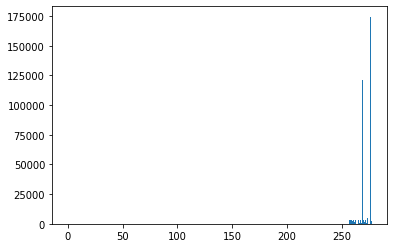

Numerical Features Plot




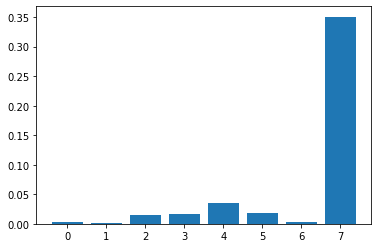

In [76]:
cat_train, num_train, results_train = calc_feature_import(X_train=train_features_no_p, 
                    y=train_labels_no_p, cat_cols=train_cat_cols, num_cols=train_num_cols, print_result=True) 

> The numerical features have just 5 features with high importance, so we would select 4 features numerical features and stick with default 10 for categorical features. many of the categorical features have less importanc ein predicting the  target variable

Categorical Features Plot




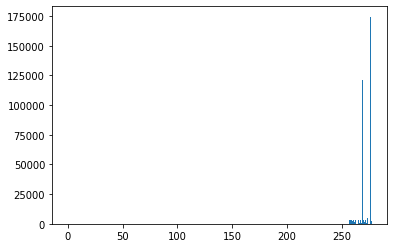

Numerical Features Plot




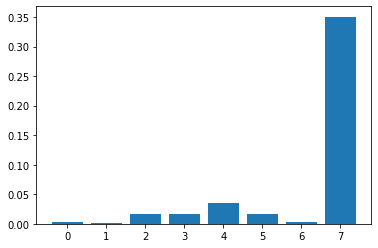

In [77]:
cat_train, num_train, results_train = calc_feature_import(X_train=train_features_no_p, 
                    y=train_labels_no_p, cat_cols=train_cat_cols, num_cols=train_num_cols, print_result=False,k_num=5, k_cat=20)

In [78]:
num_train.shape 

(611772, 5)

In [79]:
cat_train.shape

(611772, 20)

##### Concatenate important train features

In [80]:
x=pd.DataFrame(cat_train)
y = pd.DataFrame(num_train)

In [81]:
X_train_no_p = x.merge(y, left_index=True, right_index=True) 
X_train_no_p

,0_x,1_x,2_x,3_x,4_x,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0_y,1_y,2_y,3_y,4_y
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,2,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,2,1,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,2,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,2,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611767,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,1,5,0
611768,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2019,2019,1,5,0
611769,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2019,2019,1,5,0
611770,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2019,2019,1,5,5


#### Calculate feature importance for Test set

Test

In [82]:
test_features_no_p

,age,duration_till_date,year,month,week_of_year,day_of_week,birth_year,product_ranks,sex_M,marital_status_D,marital_status_F,marital_status_M,marital_status_P,marital_status_R,marital_status_S,marital_status_U,marital_status_W,branch_code_1X1H,branch_code_30H5,branch_code_49BM,branch_code_748L,branch_code_94KC,branch_code_9F9T,branch_code_BOAS,branch_code_E5SW,branch_code_EU3L,branch_code_O4JC,branch_code_O67J,branch_code_UAOD,branch_code_X23B,branch_code_XX25,branch_code_ZFER,occupation_code_00MO,occupation_code_0B60,occupation_code_0FOI,occupation_code_0KID,occupation_code_0OJM,occupation_code_0PO7,occupation_code_0S50,occupation_code_0SH6,...,occupation_code_WE0G,occupation_code_WE7U,occupation_code_WIWP,occupation_code_WMTK,occupation_code_WSID,occupation_code_WV7U,occupation_code_WVQF,occupation_code_X1JO,occupation_code_XC1N,occupation_code_XHJD,occupation_code_XVMH,occupation_code_Y1WG,occupation_code_Y7G1,occupation_code_YMGT,occupation_code_YX47,occupation_code_Z7PM,occupation_code_ZA1S,occupation_code_ZCQR,occupation_code_ZKQ3,product_ids_66FJ,product_ids_7POT,product_ids_8NN1,product_ids_AHXO,product_ids_BSTQ,product_ids_ECY3,product_ids_FM3X,product_ids_GHYX,product_ids_GYSR,product_ids_J9JW,product_ids_JWFN,product_ids_JZ9D,product_ids_K6QO,product_ids_LJR9,product_ids_N2MW,product_ids_P5DA,product_ids_PYUQ,product_ids_QBOL,product_ids_RIBP,product_ids_RVSZ,product_ids_SOP4
49842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
119842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129842,55,612,2019,2019,1,5,1964,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86019,38,978,2018,2018,1,3,1980,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
156019,38,978,2018,2018,1,3,1980,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
16019,38,978,2018,2018,1,3,1980,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
76019,38,978,2018,2018,1,3,1980,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [83]:
test_cat_cols = test_features_no_p.iloc[:,8:].columns.to_list()
test_cat_cols[:6] 

['sex_M',
 'marital_status_D',
 'marital_status_F',
 'marital_status_M',
 'marital_status_P',
 'marital_status_R']

In [84]:
test_num_cols = test_features_no_p.iloc[:,:8].columns.to_list()
test_num_cols 

['age',
 'duration_till_date',
 'year',
 'month',
 'week_of_year',
 'day_of_week',
 'birth_year',
 'product_ranks']

#### Calculate feature importance for Train set

Categorical Features


Feature 0: 0.063373

Feature 1: 0.003286

Feature 2: 0.067457

Feature 3: 1.357422

Feature 4: 0.067457

Feature 5: 0.030150

Feature 6: 0.096421

Feature 7: 16.484796

Feature 8: 0.123554

Feature 9: 17.596725

Feature 10: 2.432002

Feature 11: 3.784922

Feature 12: 0.630402

Feature 13: 0.941948

Feature 14: 3.175950

Feature 15: 1.233667

Feature 16: 4.598219

Feature 17: 0.004131

Feature 18: 0.723205

Feature 19: 0.016059

Feature 20: 3.302929

Feature 21: 0.050276

Feature 22: 0.000854

Feature 23: 12.711495

Feature 24: 0.235415

Feature 25: 0.571030

Feature 26: 0.067457

Feature 27: 0.127886

Feature 28: 18.964504

Feature 29: 0.544774

Feature 30: 0.616993

Feature 31: 0.134914

Feature 32: 0.134914

Feature 33: 0.067457

Feature 34: 0.067457

Feature 35: 0.067457

Feature 36: 0.170365

Feature 37: 0.030150

Feature 38: 1.493524

Feature 39: 0.016234

Feature 40: 0.134914

Feature 41: 0.269829

Feature 42: 3.956084

Feature 43: 3.953308

Feature 44: 0.0

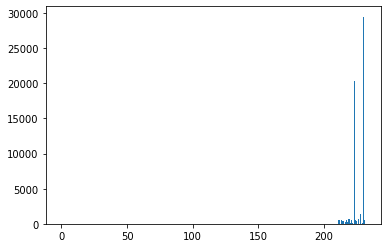

Numerical Features Plot




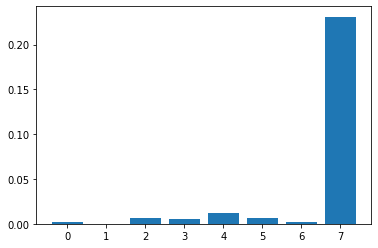

In [85]:
cat_test, num_test, results_test = calc_feature_import(X_train=test_features_no_p, 
                    y=test_labels_no_p, cat_cols=test_cat_cols, num_cols=test_num_cols, print_result=True) 

> The numerical features have just 5 features with high importance, so we would select 4 features numerical features and stick with default 10 for categorical features. many of the categorical features have less importanc ein predicting the  target variable

Categorical Features


Feature 0: 0.063373

Feature 1: 0.003286

Feature 2: 0.067457

Feature 3: 1.357422

Feature 4: 0.067457

Feature 5: 0.030150

Feature 6: 0.096421

Feature 7: 16.484796

Feature 8: 0.123554

Feature 9: 17.596725

Feature 10: 2.432002

Feature 11: 3.784922

Feature 12: 0.630402

Feature 13: 0.941948

Feature 14: 3.175950

Feature 15: 1.233667

Feature 16: 4.598219

Feature 17: 0.004131

Feature 18: 0.723205

Feature 19: 0.016059

Feature 20: 3.302929

Feature 21: 0.050276

Feature 22: 0.000854

Feature 23: 12.711495

Feature 24: 0.235415

Feature 25: 0.571030

Feature 26: 0.067457

Feature 27: 0.127886

Feature 28: 18.964504

Feature 29: 0.544774

Feature 30: 0.616993

Feature 31: 0.134914

Feature 32: 0.134914

Feature 33: 0.067457

Feature 34: 0.067457

Feature 35: 0.067457

Feature 36: 0.170365

Feature 37: 0.030150

Feature 38: 1.493524

Feature 39: 0.016234

Feature 40: 0.134914

Feature 41: 0.269829

Feature 42: 3.956084

Feature 43: 3.953308

Feature 44: 0.0

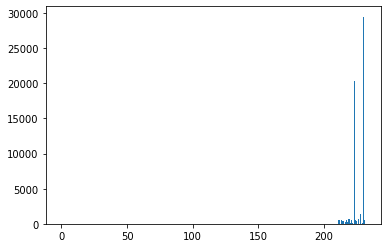

Numerical Features Plot




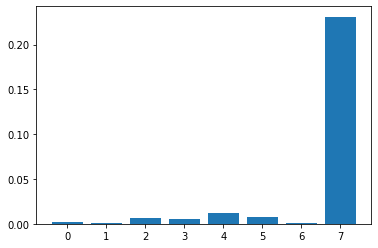

In [86]:
cat_test, num_test, results_test = calc_feature_import(X_train=test_features_no_p, 
                    y=test_labels_no_p, cat_cols=test_cat_cols, num_cols=test_num_cols, print_result=True, k_num=5, k_cat=20)

In [87]:
num_test.shape 

(210000, 5)

In [88]:
cat_test.shape

(210000, 20)

> Concatenate the matrix as predictor variables for training our models

In [89]:
x=pd.DataFrame(cat_test)
y = pd.DataFrame(num_test)

In [90]:
X_test_no_p = x.merge(y, left_index=True, right_index=True) 
X_test_no_p

,0_x,1_x,2_x,3_x,4_x,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0_y,1_y,2_y,3_y,4_y
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,1,5,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,1,5,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,1,5,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,1,5,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018,2018,1,3,0
209996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2018,2018,1,3,0
209997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2018,2018,1,3,0
209998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2018,2018,1,3,0


#### All done !

In [91]:
X_test_no_p

,0_x,1_x,2_x,3_x,4_x,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0_y,1_y,2_y,3_y,4_y
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,1,5,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,1,5,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,1,5,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,1,5,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018,2018,1,3,0
209996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2018,2018,1,3,0
209997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2018,2018,1,3,0
209998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2018,2018,1,3,0


In [92]:
X_train_no_p

,0_x,1_x,2_x,3_x,4_x,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0_y,1_y,2_y,3_y,4_y
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,2,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,2,1,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,2,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,2,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611767,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,2019,1,5,0
611768,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2019,2019,1,5,0
611769,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2019,2019,1,5,0
611770,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2019,2019,1,5,5


### Perform PCA on the new features

> determine number of components using the cummulative explianed variance ration - becuase the data is sparse, i would be working with the TruncatedSVD

#### Train

In [93]:
pca_train = TruncatedSVD(n_components = X_train_no_p.shape[1]-1).fit(X_train_no_p) 

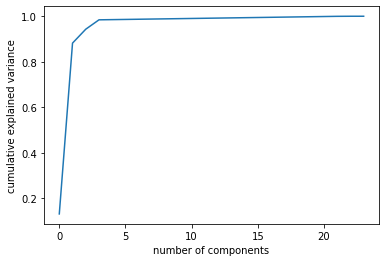

In [94]:
plt.plot(np.cumsum(pca_train.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance'); 

> I would define a fucntion to calcuate the required number of components that explains the dataset to a certain percentage

> I would be optimsing for 95% explainalbiility

In [95]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [96]:
train_var_ratio = pca_train.explained_variance_ratio_
train_var_ratio

array([1.31286982e-01, 7.50658608e-01, 6.11092150e-02, 4.12092489e-02,
       8.53310339e-04, 8.53310339e-04, 8.53310339e-04, 8.53310339e-04,
       8.53310339e-04, 8.53310339e-04, 8.53310339e-04, 8.53310339e-04,
       8.53310339e-04, 8.53310339e-04, 8.53310339e-04, 8.53310339e-04,
       8.53310339e-04, 8.53310339e-04, 8.53310339e-04, 8.53310339e-04,
       8.53310339e-04, 8.53310339e-04, 3.35778892e-04, 4.05808222e-05])

In [97]:
select_n_components(train_var_ratio, goal_var=.95)

4

4 components are needed to explain the variance of the features -> this also mathces what is in the graph at compoent 4, there was no much changes again







#### Test

In [98]:
pca_test = TruncatedSVD(n_components = X_test_no_p.shape[1]-1).fit(X_test_no_p) 

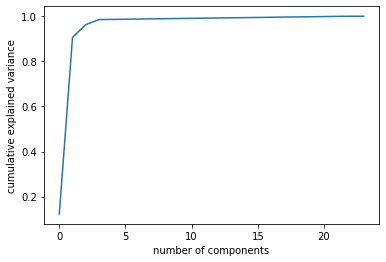

In [99]:
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance'); 

> I would define a fucntion to calcuate the required number of components that explains the dataset to a certain percentage

> I would be optimsing for 95% explainalbiility

In [100]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [101]:
test_var_ratio = pca_test.explained_variance_ratio_
test_var_ratio

array([1.23425576e-01, 7.82946842e-01, 5.64473926e-02, 2.24168693e-02,
       7.87915463e-04, 7.87915463e-04, 7.87915463e-04, 7.87915463e-04,
       7.87915463e-04, 7.87915463e-04, 7.87915463e-04, 7.87915463e-04,
       7.87915463e-04, 7.87915463e-04, 7.87915463e-04, 7.87915463e-04,
       7.87915463e-04, 7.87915463e-04, 7.87915463e-04, 7.87915463e-04,
       7.87915463e-04, 7.87915463e-04, 5.43328217e-04, 3.75129160e-05])

In [102]:
select_n_components(test_var_ratio, goal_var=.95)

3

*3* components are needed to explain the variance of the features -> this also mathces what is in the graph at compoent 3, there was no much changes again







### Decomposing Features into Components

In [ ]:
TruncatedSVD()

#### Build Models from non-penalized datasets and compare performance with penalized- datasets


> Check Class Imbalance

In [ ]:
(test_set_no_penalize.labels.sum()/test_set_no_penalize.shape[0])*100

6.12047619047619

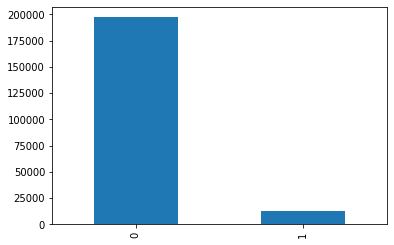

In [ ]:
test_set_no_penalize.labels.value_counts().plot.bar();

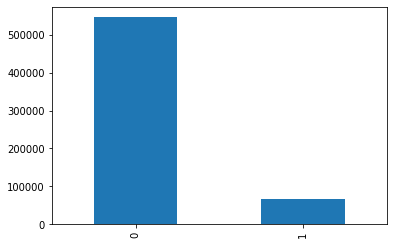

In [ ]:
train_set_penalize.labels.value_counts().plot.bar();

### set class weight for catboost

In [ ]:
class_weight = [1,test_set.labels.value_counts()[0]/test_set.labels.value_counts()[1]]
class_weight

[1, 15.338597992686532]

> convert all int  type to float type

In [ ]:
train_set.dtypes

ID                    object
ID X PCODE            object
age                    int64
duration_till_date     int64
year                   int64
month                  int64
week_of_year           int64
day_of_week            int64
sex                   object
marital_status        object
birth_year             int64
branch_code           object
occupation_code       object
product_ids           object
product_ranks          int64
labels                 int64
dtype: object

In [ ]:
for i in train_set.select_dtypes('int64').columns.to_list():
    train_set[i] = train_set[i].astype('float')

In [ ]:
train_set.dtypes

ID                    object
ID X PCODE            object
age                    int64
duration_till_date     int64
year                   int64
month                  int64
week_of_year           int64
day_of_week            int64
sex                   object
marital_status        object
birth_year             int64
branch_code           object
occupation_code       object
product_ids           object
product_ranks          int64
labels                 int64
dtype: object

In [ ]:
test_set.dtypes#('int64').astype('float')

ID                    object
ID X PCODE            object
age                    int64
duration_till_date     int64
year                   int64
month                  int64
week_of_year           int64
day_of_week            int64
sex                   object
marital_status        object
birth_year             int64
branch_code           object
occupation_code       object
product_ids           object
product_ranks          int64
labels                 int64
dtype: object

In [ ]:
for i in test_set.select_dtypes('int64').columns.to_list():
    test_set[i] = test_set[i].astype('float')

In [ ]:
test_set.dtypes

ID                     object
ID X PCODE             object
age                   float64
duration_till_date    float64
year                  float64
month                 float64
week_of_year          float64
day_of_week           float64
sex                    object
marital_status         object
birth_year            float64
branch_code            object
occupation_code        object
product_ids            object
product_ranks         float64
labels                float64
dtype: object

### Modelling

Algorithms:

- Catboost

- XGboost

- LGBM

Techniques

- cross validation

- hp-tuning

- over-sampling imbalance

#### Test Catboost Using Cross Validation

In [ ]:
X_cat_train, y_cat_train = train_set.drop(columns=['labels', 'ID', 'ID X PCODE' 
                                                  ],axis=1), train_set.labels 

In [ ]:
X_cat_train

,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,product_ranks
135107,36,607,2019,2019,2,1,F,M,1983,9F9T,31JW,66FJ,0
105975,36,607,2019,2019,2,1,F,M,1983,9F9T,31JW,7POT,0
76843,36,607,2019,2019,2,1,F,M,1983,9F9T,31JW,8NN1,0
339031,36,607,2019,2019,2,1,F,M,1983,9F9T,31JW,AHXO,0
368163,36,607,2019,2019,2,1,F,M,1983,9F9T,31JW,BSTQ,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260571,25,610,2019,2019,1,5,M,M,1994,94KC,2A7I,PYUQ,0
464495,25,610,2019,2019,1,5,M,M,1994,94KC,2A7I,QBOL,0
56647,25,610,2019,2019,1,5,M,M,1994,94KC,2A7I,RIBP,0
231439,25,610,2019,2019,1,5,M,M,1994,94KC,2A7I,RVSZ,5


In [ ]:
y_cat_train

135107    0
105975    0
76843     0
339031    0
368163    0
         ..
260571    0
464495    0
56647     0
231439    1
202307    0
Name: labels, Length: 611772, dtype: int64

> Deal with Imbalances

In [ ]:

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=2)
# X_cat_train, y_cat_train = sm.fit_sample(X_cat_train, y_cat_train.ravel())

> get column indices of categorical variables

In [ ]:
cat_features = np.where((X_cat_train.dtypes != np.float))[0]
cat_features

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
feature_names = X_cat_train.columns.tolist()
feature_names

['age',
 'duration_till_date',
 'year',
 'month',
 'week_of_year',
 'day_of_week',
 'sex',
 'marital_status',
 'birth_year',
 'branch_code',
 'occupation_code',
 'product_ids',
 'product_ranks']

In [ ]:
X_cat_train_array = X_cat_train.values

In [ ]:
X_cat_train_array

array([[36, 607, 2019, ..., '31JW', '66FJ', 0],
       [36, 607, 2019, ..., '31JW', '7POT', 0],
       [36, 607, 2019, ..., '31JW', '8NN1', 0],
       ...,
       [25, 610, 2019, ..., '2A7I', 'RIBP', 0],
       [25, 610, 2019, ..., '2A7I', 'RVSZ', 5],
       [25, 610, 2019, ..., '2A7I', 'SOP4', 0]], dtype=object)

In [ ]:
y_cat_train_array = y_cat_train.values
y_cat_train_array

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

> Split  train data into train and validation

In [ ]:
X_train1, X_validation1, y_train1, y_validation1 = train_test_split(X_cat_train_array,
                                                                y_cat_train_array, train_size=0.8, random_state=1234)

In [ ]:
y_train1.shape

(489417,)

> Create Catboost object and define objective function/parameters

loss function: -> 
 - log loss for binary classification
 
 - cross entropy for target probability

catboost class_weights would be used to handle class imbalance

In [ ]:
cat_model_no_cv = CatBoostClassifier(loss_function="Logloss",
                           eval_metric="AUC",
                           learning_rate=0.01,
                           iterations=1000,
                           random_seed=42,
                                     l2_leaf_reg=3,
                           od_type="Iter",
                           depth=10,
                          task_type = 'GPU',
                           early_stopping_rounds=100, 
                           #class_weights=  {0:class_weight[0], 1:class_weight[1]},
                           auto_class_weights="Balanced", # automatically calcualte weihts for imbalanced sets,
                           data_partition ='FeatureParallel', 
                          metric_period=4 , #t is recommended to increase the value of this parameter to maintain training speed if a GPU processing unit type is used.,
                          # thread_count =4,
                        #   early_stopping_rounds=True
                              )

> store cat_model parameter

In [ ]:
cat_params_no_cv = dict(cat_model_no_cv.get_params())
cat_params_no_cv

{'auto_class_weights': 'Balanced',
 'data_partition': 'FeatureParallel',
 'depth': 10,
 'early_stopping_rounds': 100,
 'eval_metric': 'AUC',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'learning_rate': 0.01,
 'loss_function': 'Logloss',
 'metric_period': 4,
 'od_type': 'Iter',
 'random_seed': 42,
 'task_type': 'GPU'}

In [ ]:
#cv?

In [ ]:
#Pool?

> create data pool to fit into  CatBoost

In [ ]:
cat_pool = Pool(data=X_train1, label=y_train1, 
                cat_features=cat_features, feature_names=feature_names)

> Pool info

In [ ]:
cat_pool_params = [cat_pool.get_cat_feature_indices(), cat_pool.get_feature_names(), cat_pool.shape]
for i in cat_pool_params:
    print('*'*25)
    print(f"{i}")

*************************
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
*************************
['age', 'duration_till_date', 'year', 'month', 'week_of_year', 'day_of_week', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'product_ids', 'product_ranks']
*************************
(489417, 13)


### Cross-validate the CatBoost model.

In [ ]:
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [ ]:
pool_cv = cv(pool=cat_pool, params= cat_params_no_cv, stratified=True, folds=sf, verbose=True,
             as_pandas=True)
pool_cv

0:	test: 1.0000000	best: 1.0000000 (0)
4:	test: 1.0000000	best: 1.0000000 (0)
8:	test: 1.0000000	best: 1.0000000 (0)
12:	test: 1.0000000	best: 1.0000000 (0)
16:	test: 1.0000000	best: 1.0000000 (0)
20:	test: 1.0000000	best: 1.0000000 (0)
24:	test: 1.0000000	best: 1.0000000 (0)
28:	test: 1.0000000	best: 1.0000000 (0)
32:	test: 1.0000000	best: 1.0000000 (0)
36:	test: 1.0000000	best: 1.0000000 (0)
40:	test: 1.0000000	best: 1.0000000 (0)
44:	test: 1.0000000	best: 1.0000000 (0)
48:	test: 1.0000000	best: 1.0000000 (0)
52:	test: 1.0000000	best: 1.0000000 (0)
56:	test: 1.0000000	best: 1.0000000 (0)
60:	test: 1.0000000	best: 1.0000000 (0)
64:	test: 1.0000000	best: 1.0000000 (0)
68:	test: 1.0000000	best: 1.0000000 (0)
72:	test: 1.0000000	best: 1.0000000 (0)
76:	test: 1.0000000	best: 1.0000000 (0)
80:	test: 1.0000000	best: 1.0000000 (0)
84:	test: 1.0000000	best: 1.0000000 (0)
88:	test: 1.0000000	best: 1.0000000 (0)
92:	test: 1.0000000	best: 1.0000000 (0)
96:	test: 1.0000000	best: 1.0000000 (0)
Sto

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,1.0,0.0,0.640087,2.364178e-07,0.640089,0.000003
1,4,1.0,0.0,0.464767,1.926300e-03,0.464673,0.001941
2,8,1.0,0.0,0.331391,1.799886e-03,0.331485,0.001731
3,12,1.0,0.0,0.235292,2.342069e-03,0.235409,0.002321
4,16,1.0,0.0,0.166395,3.206788e-03,0.166487,0.003198
5,20,1.0,0.0,0.117060,2.982495e-03,0.117215,0.003001
6,24,1.0,0.0,0.082650,2.891943e-03,0.082798,0.002869
7,28,1.0,0.0,0.058767,2.780682e-03,0.058910,0.002755
8,32,1.0,0.0,0.041981,2.502581e-03,0.042102,0.002460
9,36,1.0,0.0,0.030170,2.166832e-03,0.030268,0.002115


#### Model without cross validation

In [ ]:
? cat_model_no_cv.fit

In [ ]:
cat_model_no_cv.fit(X=cat_pool,
  eval_set=(X_validation1, y_validation1), #serves as test set for use_best_model,
          verbose=True,use_best_model=True, metric_period=10)

0:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 83.9ms	remaining: 1m 23s
10:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 1.1s	remaining: 1m 38s
20:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 2.41s	remaining: 1m 52s
30:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.72s	remaining: 1m 56s
40:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 5.04s	remaining: 1m 57s
50:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.37s	remaining: 1m 58s
60:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 7.7s	remaining: 1m 58s
70:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 9.02s	remaining: 1m 58s
80:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 10.3s	remaining: 1m 57s
90:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 11.7s	remaining: 1m 56s
100:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 13s	remaining: 1m 55s
bestTest = 1
bestIteration = 0
Shri

#### Evaluate Model Perofrmance

In [ ]:
from catboost.utils import get_confusion_matrix, get_roc_curve

In [ ]:
cat_model_no_cv.best_score_

{'learn': {'AUC': 1.0, 'Logloss': 0.0010171171354150695},
 'validation': {'AUC': 1.0, 'Logloss': 0.0012461908258744674}}

In [ ]:
get_confusion_matrix(cat_model_no_cv, cat_pool)

array([[436168.,      0.],
       [     0.,  53249.]])

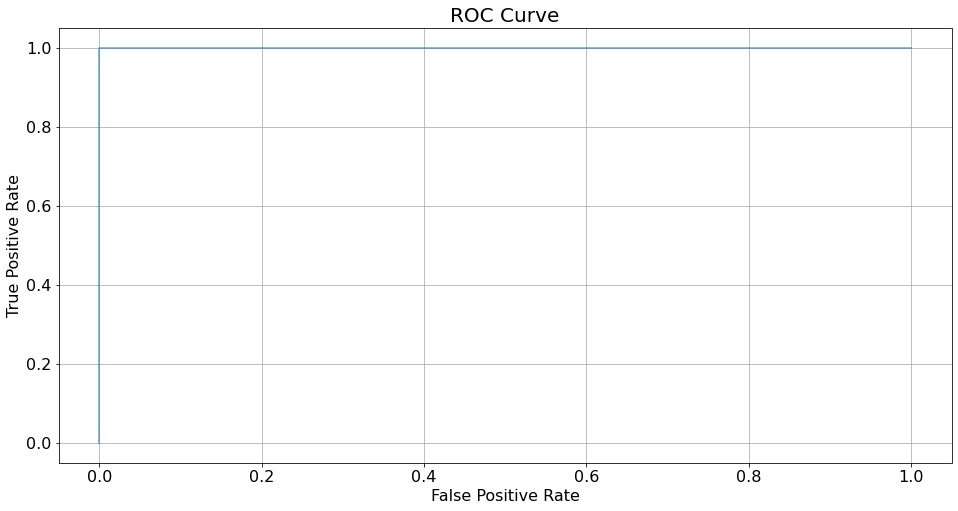

In [ ]:
roc_curve1 = get_roc_curve(model=cat_model_no_cv, data=cat_pool, plot=True)

#### Sanity Checks

> Run predictions with holdout test data

> > calculate logloss

In [ ]:
X_cat_test=test_set.drop(columns=['labels', 'ID', 'ID X PCODE'
                                                  ],axis=1)

In [ ]:
y_cat_test_array = test_set.labels.values

In [ ]:
X_cat_test_array = X_cat_test.values
X_cat_test_array

array([[55, 610, 2019, ..., '0KID', '66FJ', 0],
       [55, 610, 2019, ..., '0KID', '7POT', 0],
       [55, 610, 2019, ..., '0KID', '8NN1', 0],
       ...,
       [38, 976, 2018, ..., 'SST3', 'RIBP', 0],
       [38, 976, 2018, ..., 'SST3', 'RVSZ', 0],
       [38, 976, 2018, ..., 'SST3', 'SOP4', 0]], dtype=object)

In [ ]:
main_predictions = cat_model_no_cv.predict(data=X_cat_test_array).astype('int64') #verbose=True
main_predictions

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
log_loss(y_pred=main_predictions, y_true=y_cat_test_array)

9.99200722162641e-16

> Cross validation score

In [ ]:
# cross_val_score(cat_model_no_cv,X= X_cat_train_array, y=y_cat_train_array)

#### Save satisifed predictions

In [ ]:
submissions = pd.DataFrame({'ID X PCODE':test_set['ID X PCODE'],'Label':main_predictions})

In [ ]:
submissions

,ID X PCODE,Label
49842,0021EE1 X 66FJ,0
39842,0021EE1 X 7POT,0
29842,0021EE1 X 8NN1,0
119842,0021EE1 X AHXO,0
129842,0021EE1 X BSTQ,0
...,...,...
86019,ZZYM5CT X PYUQ,0
156019,ZZYM5CT X QBOL,0
16019,ZZYM5CT X RIBP,0
76019,ZZYM5CT X RVSZ,0


> Save predictions

In [ ]:
submissions.to_csv('/content/drive/My Drive/Zindi-Competionts/zimnat_Challenge_predicting_insurance_purchase/submissions/submissions_patrick_no_cv.csv', index=False)

> Save model

In [ ]:
cat_model_no_cv.save_model('/content/drive/My Drive/Zindi-Competionts/zimnat_Challenge_predicting_insurance_purchase/saved_models/catboost_model_2.json', format='json')

#### Model With Cross Validation - Using Grid Search

> Retrain model to avoid data leakage

In [ ]:
cat_model_cv = CatBoostClassifier()

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
sf = StratifiedKFold(random_state=123, shuffle=True)
kf = KFold(shuffle=True, random_state=123)

In [ ]:
y_cat_train_array.ravel()

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [ ]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cat_train_array,
                                                                y_cat_train_array,
                                                               shuffle=True,
                                                        random_state=123,
                                                        train_size=0.8,
                                                        stratify=y_cat_train_array
                                                               )

In [ ]:
X_train_cv

array([[46, 248, 2020, ..., 'FSXG', '7POT', 0],
       [45, 1702, 2016, ..., 'U9RX', '7POT', 0],
       [45, 974, 2018, ..., '2A7I', 'K6QO', 5],
       ...,
       [22, 604, 2019, ..., 'UJ5T', 'GYSR', 0],
       [32, 2066, 2015, ..., 'PMAI', 'ECY3', 0],
       [56, 245, 2020, ..., '2XZ1', '66FJ', 0]], dtype=object)

In [ ]:
y_train_cv

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [ ]:
cat_pool = Pool(data=X_train_cv, label=y_train_cv, 
                cat_features=cat_features, feature_names=feature_names)

In [ ]:
params = {#'loss_function': ["Logloss","CrossEntropy", "MultiClass"],
          #  "eval_metric":["AUC", "Accuracy"],
        
            'l2_leaf_reg':np.logspace(-20, -19, 3),
                         #  od_type="Iter",
                          # task_type = 'GPU',
                          # early_stopping_rounds=100, 
          'random_seed': [123],
          'class_weights': class_weight,                        
          'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],  
          'l2_leaf_reg':[3,1,5,10,100],
         # 'border_count':[32,5,10,20,50,200],
          'ctr_border_count':[50,5,10,20,100,200],
         # 'thread_count':[4], #used for cpu
           'task_type':['GPU'] 
         }

In [ ]:
params

{'class_weights': [1, 15.338597992686532],
 'ctr_border_count': [50, 5, 10, 20, 100, 200],
 'depth': [3, 1, 2, 6, 4, 5, 7, 8, 9, 10],
 'iterations': [250, 100, 500, 1000],
 'l2_leaf_reg': [3, 1, 5, 10, 100],
 'learning_rate': [0.03, 0.001, 0.01, 0.1, 0.2, 0.3],
 'random_seed': [123],
 'task_type': ['GPU']}

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, log_loss
scorer = make_scorer(log_loss)

In [ ]:
cat_grid = cat_model_cv.grid_search(params,X=cat_pool,
                         cv=sf, search_by_train_test_split=False) 

> Use Catboost Gridsearch

In [ ]:
cat_grid

{'cv_results': defaultdict(list, {}), 'params': {}}